pandas 已安装
matplotlib 已安装
seaborn 已安装
numpy 已安装
中文字体启用： SimHei


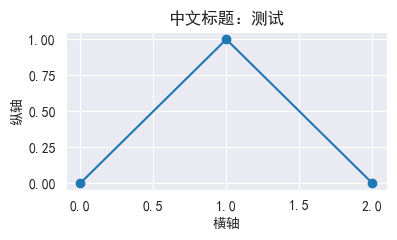

In [1]:

# ✓ 依赖安装 + Matplotlib 中文字体自动配置
import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
        print(f"{pkg} 已安装")
    except ImportError:
        print(f"正在安装 {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for pkg in ("pandas", "matplotlib", "seaborn", "numpy"):
    ensure(pkg)

import os, urllib.request
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# 1) 尝试使用常见中文字体
preferred = [
    "SimHei", "Microsoft YaHei", "PingFang SC", "Hiragino Sans GB",
    "Source Han Sans CN", "Source Han Sans SC", "Noto Sans CJK SC",
    "Noto Sans SC", "WenQuanYi Zen Hei", "Sarasa Gothic SC"
]
available = set(f.name for f in fm.fontManager.ttflist)
picked = None
for name in preferred:
    if name in available:
        picked = name
        break

# 2) 如无中文字体，自动下载 Noto Sans SC 并注册（需要外网）
if picked is None:
    print("未检测到本地中文字体，尝试下载 Noto Sans SC ...")
    url = "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansSC-Regular.otf"
    font_dir = Path.home() / ".local" / "share" / "fonts"
    font_dir.mkdir(parents=True, exist_ok=True)
    font_path = font_dir / "NotoSansSC-Regular.otf"
    if not font_path.exists():
        try:
            urllib.request.urlretrieve(url, font_path.as_posix())
            print("Noto Sans SC 下载完成")
        except Exception as e:
            print("字体下载失败：", e)
    # 运行时动态注册
    if font_path.exists():
        fm.fontManager.addfont(font_path.as_posix())
        matplotlib.rcParams['font.sans-serif'] = ["Noto Sans SC"]
        picked = "Noto Sans SC"

# 3) 配置 Matplotlib
if picked:
    matplotlib.rcParams['font.sans-serif'] = [picked]
matplotlib.rcParams['axes.unicode_minus'] = False
print("中文字体启用：", picked or "（未成功配置中文字体）")

# 小测试
import numpy as np
plt.figure(figsize=(4,2.5))
plt.title("中文标题：测试")
plt.xlabel("横轴")
plt.ylabel("纵轴")
plt.plot([0,1,2],[0,1,0], "o-")
plt.tight_layout()
plt.show()


# CN_13 — Model Evaluation, Selection, and Interpretation

This notebook consolidates Python code extracted from your LaTeX chapter, with **minimal fixes** to ensure it runs **offline** and **without external downloads**.
We use synthetic datasets where needed (e.g., instead of deprecated or online datasets) and correct syntax issues found in the original snippets.


In [2]:
# Global setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, roc_auc_score,
    roc_curve, precision_recall_curve, auc, r2_score
)
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

torch.manual_seed(42)
np.random.seed(42)

print('Environment ready. Torch:', torch.__version__)


Environment ready. Torch: 2.8.0+cpu


## 1. Classification metrics (confusion matrix, precision, recall, F1)

In [3]:
# Fixed version of the initial (broken) PyTorch snippet for confusion matrix metrics
y_true = torch.tensor([1, 0, 1, 1, 0, 0, 1, 0])
y_pred = torch.tensor([1, 0, 0, 1, 0, 1, 1, 0])

TP = ((y_pred == 1) & (y_true == 1)).sum().item()
TN = ((y_pred == 0) & (y_true == 0)).sum().item()
FP = ((y_pred == 1) & (y_true == 0)).sum().item()
FN = ((y_pred == 0) & (y_true == 1)).sum().item()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print(f"Accuracy={accuracy:.2f}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")

TP=3, TN=3, FP=1, FN=1
Accuracy=0.75, Precision=0.75, Recall=0.75, F1=0.75


### ROC/PR curves with a simple classifier

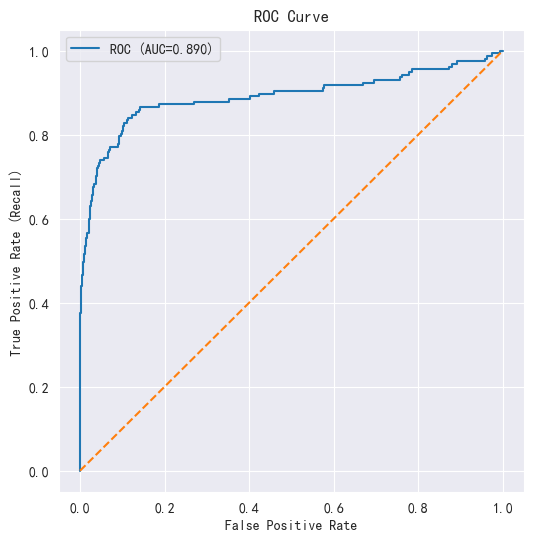

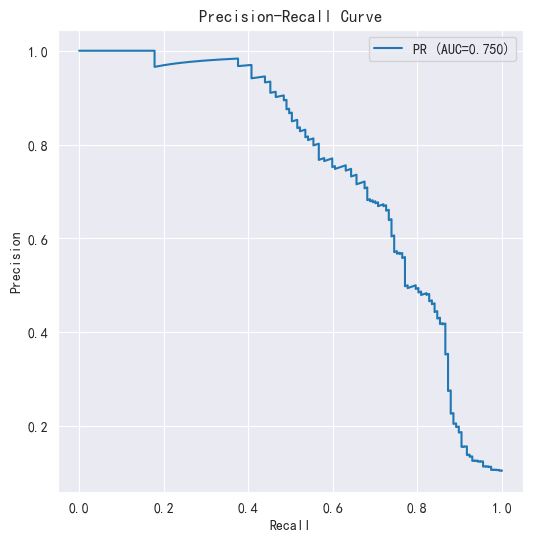

In [4]:
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=5000, n_features=20, n_informative=10,
                           weights=[0.9, 0.1], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_score)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f'PR (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Threshold tuning on imbalanced data (neural network demo)

Epoch 1/10, Loss: 0.2732
Epoch 2/10, Loss: 0.1832
Epoch 3/10, Loss: 0.1658
Epoch 4/10, Loss: 0.1551
Epoch 5/10, Loss: 0.1452
Epoch 6/10, Loss: 0.1374
Epoch 7/10, Loss: 0.1302
Epoch 8/10, Loss: 0.1253
Epoch 9/10, Loss: 0.1206
Epoch 10/10, Loss: 0.1168


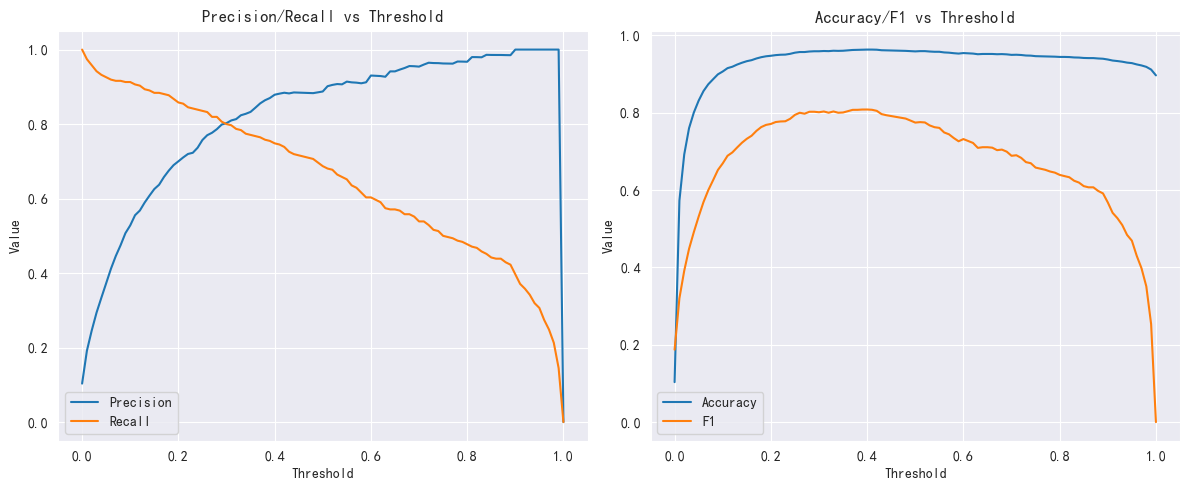

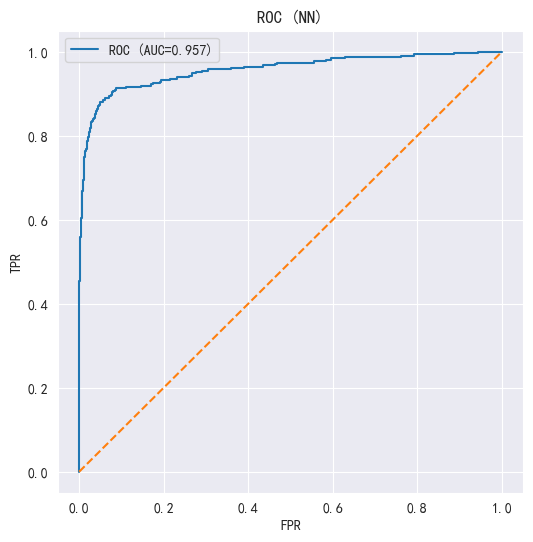

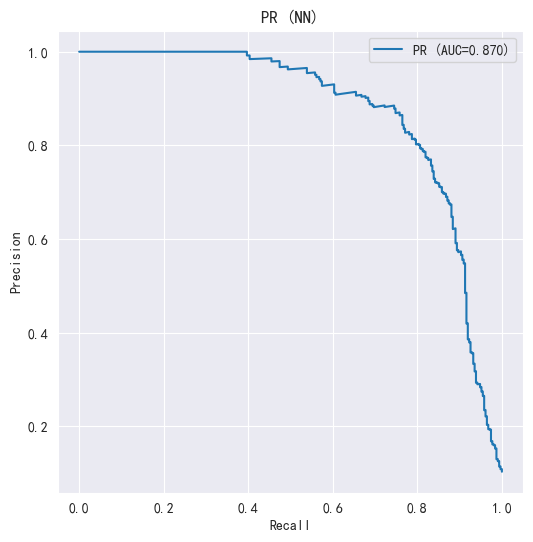

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Synthetic imbalanced data
X, y = make_classification(
    n_samples=10000, n_features=20, n_informative=10, n_redundant=5,
    n_classes=2, weights=[0.9, 0.1], flip_y=0.01, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze()

model = Classifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_dl, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for xb, yb in train_dl:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_dl.dataset):.4f}")

train_model(model, train_dl, epochs=10)

# Evaluate
model.eval()
with torch.no_grad():
    y_scores = model(X_test_t).numpy()
    y_true = y_test_t.numpy()

thresholds = np.linspace(0, 1, 101)
precisions, recalls, accuracies, f1_scores = [], [], [], []
for thresh in thresholds:
    y_pred = (y_scores >= thresh).astype(int)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    accuracy = (TP + TN) / len(y_true)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    precisions.append(precision); recalls.append(recall)
    accuracies.append(accuracy); f1_scores.append(f1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Value')
plt.title('Precision/Recall vs Threshold')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1')
plt.xlabel('Threshold'); plt.ylabel('Value')
plt.title('Accuracy/F1 vs Threshold')
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# ROC / PR for the NN
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (NN)'); plt.legend(); plt.grid(True); plt.show()

prec, rec, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f'PR (AUC={pr_auc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR (NN)'); plt.legend(); plt.grid(True); plt.show()

## 2. Regression metrics (MSE, RMSE, MAE) — PyTorch example

MSE: 40.0000
RMSE: 6.3246
MAE: 6.0000


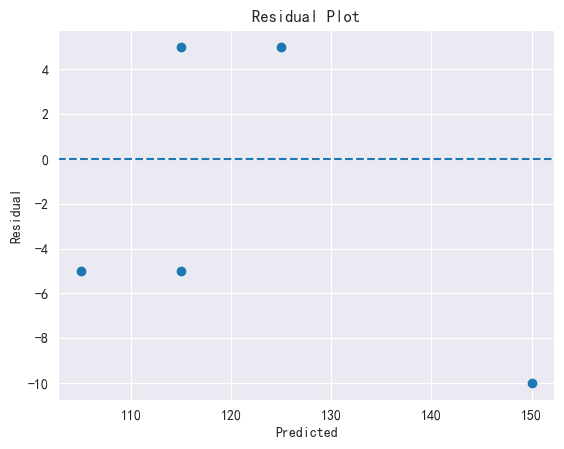

In [6]:
y_true = torch.tensor([100.0, 120.0, 130.0, 140.0, 110.0])
y_pred = torch.tensor([105.0, 115.0, 125.0, 150.0, 115.0])

mse = F.mse_loss(y_pred, y_true)
rmse = torch.sqrt(mse)
mae = torch.mean(torch.abs(y_true - y_pred))

print(f"MSE: {mse.item():.4f}")
print(f"RMSE: {rmse.item():.4f}")
print(f"MAE: {mae.item():.4f}")

# Residual plot
residuals = y_true - y_pred
plt.scatter(y_pred.numpy(), residuals.numpy())
plt.axhline(y=0, linestyle='--')
plt.xlabel('Predicted'); plt.ylabel('Residual'); plt.title('Residual Plot')
plt.show()

### Extended regression example (synthetic data instead of deprecated Boston dataset)

Epoch 10/50, Loss: 719.1881
Epoch 20/50, Loss: 427.8911
Epoch 30/50, Loss: 265.1348
Epoch 40/50, Loss: 207.5660
Epoch 50/50, Loss: 187.6870

Test Metrics:
MSE: 295.882
RMSE: 17.201
MAE: 13.769
R2 Score: 0.993


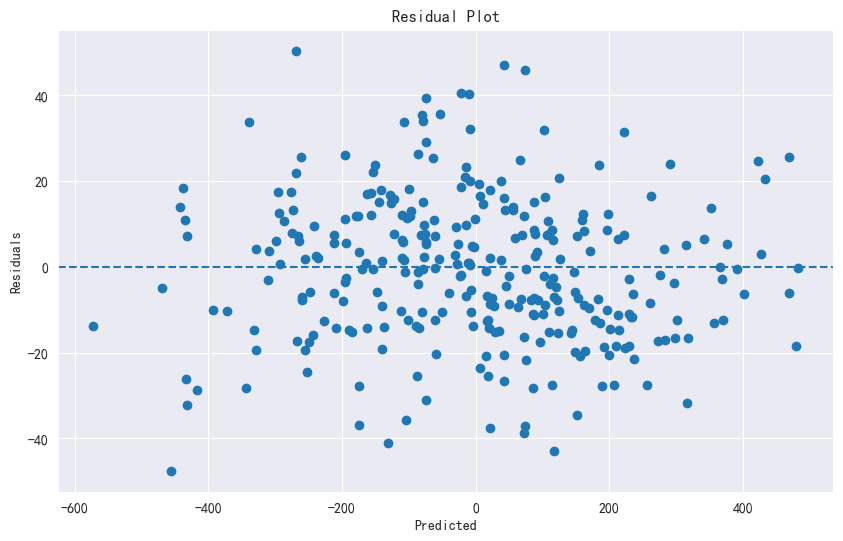

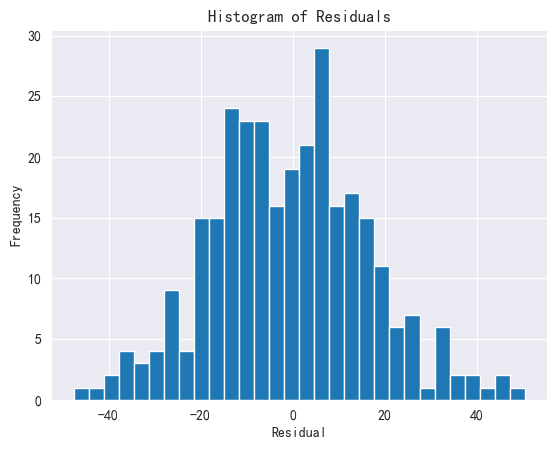

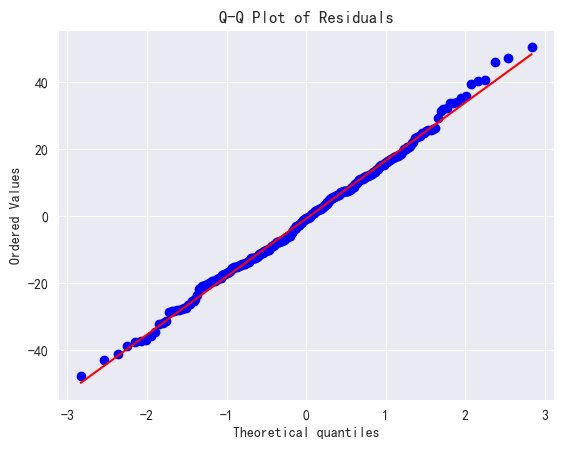

In [7]:
from sklearn.model_selection import train_test_split

# Synthetic regression data (e.g., economic values)
X, y = make_regression(n_samples=1000, n_features=12, noise=15, random_state=7)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = RegressionModel(input_dim=X_train_t.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_dl, epochs=50):
    model.train()
    for epoch in range(epochs):
        total = 0.0
        for xb, yb in train_dl:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total += loss.item() * xb.size(0)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/50, Loss: {total/len(train_dl.dataset):.4f}")

train_model(model, train_dl, epochs=50)

# Evaluate
model.eval()
with torch.no_grad():
    preds_test = model(X_test_t).squeeze()
    y_true = y_test_t.squeeze()

mse = criterion(preds_test, y_true).item()
rmse = float(torch.sqrt(criterion(preds_test, y_true)))
mae = float(torch.mean(torch.abs(preds_test - y_true)))
r2 = r2_score(y_true.numpy(), preds_test.numpy())

print(f"\nTest Metrics:\nMSE: {mse:.3f}\nRMSE: {rmse:.3f}\nMAE: {mae:.3f}\nR2 Score: {r2:.3f}")

# Residual diagnostics
residuals = y_true - preds_test
plt.figure(figsize=(10,6))
plt.scatter(preds_test.numpy(), residuals.numpy())
plt.axhline(y=0, linestyle='--')
plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('Residual Plot'); plt.show()

plt.hist(residuals.numpy(), bins=30)
plt.xlabel('Residual'); plt.ylabel('Frequency'); plt.title('Histogram of Residuals'); plt.show()

stats.probplot(residuals.numpy(), dist='norm', plot=plt); plt.title('Q-Q Plot of Residuals'); plt.show()

## 3. Cross-validation — KFold (regression)

In [8]:
# KFold CV for a small regression NN
X, y = make_regression(n_samples=500, n_features=10, noise=10, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 1))
    def forward(self, x): return self.net(x)

criterion = nn.MSELoss()

def train_model(model, train_loader, epochs=30, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

cv_losses = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
    model = RegressionModel(input_dim=X.shape[1])
    train_model(model, train_loader, epochs=30)
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            loss = criterion(model(xb), yb).item()
            losses.append(loss)
    avg_val = float(np.mean(losses))
    cv_losses.append(avg_val)
    print(f"Fold {fold+1} Validation MSE: {avg_val:.4f}")
print(f"Average Cross-Validation MSE: {np.mean(cv_losses):.4f}")

Fold 1 Validation MSE: 262.6306
Fold 2 Validation MSE: 237.7253
Fold 3 Validation MSE: 247.2140
Fold 4 Validation MSE: 237.0443
Fold 5 Validation MSE: 241.0052
Average Cross-Validation MSE: 245.1239


### Stratified K-Fold (classification)

In [9]:
# Imbalanced classification CV
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2,
                           weights=[0.9, 0.1], flip_y=0.01, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X, y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class ClassifierNet(nn.Module):
    def __init__(self, input_dim=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x): return self.net(x)

criterion = nn.CrossEntropyLoss()

def train_classifier(model, loader, epochs=20, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            loss = criterion(model(xb), yb)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

accuracies = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(dataset, val_idx), batch_size=64, shuffle=False)
    model = ClassifierNet(input_dim=X.shape[1])
    train_classifier(model, train_loader, epochs=20)
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = torch.argmax(model(xb), dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    accuracies.append(acc)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
print(f"Average Stratified K-Fold Accuracy: {np.mean(accuracies):.4f}")

Fold 1 Accuracy: 0.9100
Fold 2 Accuracy: 0.9300
Fold 3 Accuracy: 0.9000
Fold 4 Accuracy: 0.8950
Fold 5 Accuracy: 0.9200
Average Stratified K-Fold Accuracy: 0.9110


### Time-series cross-validation (synthetic series without internet)

In [10]:
# Create a synthetic time series (sine + noise)
T = 600
t = np.arange(T)
y = 10 + 2*np.sin(2*np.pi*t/50) + np.random.normal(scale=0.5, size=T)
X = t.reshape(-1, 1).astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

X_t = torch.tensor(X_scaled, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_t, y_t)

def time_series_cv_split(n_samples, n_splits=5):
    fold_size = n_samples // (n_splits + 1)
    splits = []
    for i in range(n_splits):
        train_end = fold_size * (i + 1)
        test_end = fold_size * (i + 2)
        train_idx = list(range(train_end))
        test_idx = list(range(train_end, test_end))
        splits.append((train_idx, test_idx))
    return splits

splits = time_series_cv_split(len(dataset), n_splits=5)

class TSRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 1))
    def forward(self, x): return self.net(x)

criterion = nn.MSELoss()

def train_reg(model, loader, epochs=30, lr=0.01):
    opt = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            loss = criterion(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()

mse_scores = []
for fold, (tr, te) in enumerate(splits):
    train_loader = DataLoader(Subset(dataset, tr), batch_size=64, shuffle=False)
    test_loader = DataLoader(Subset(dataset, te), batch_size=64, shuffle=False)
    model = TSRegressor(); train_reg(model, train_loader, epochs=30)
    model.eval(); losses = []
    with torch.no_grad():
        for xb, yb in test_loader:
            losses.append(criterion(model(xb), yb).item())
    avg = float(np.mean(losses)); mse_scores.append(avg)
    print(f'Time-Series Fold {fold+1} MSE: {avg:.4f}')
print(f'Average Time-Series CV MSE: {np.mean(mse_scores):.4f}')

Time-Series Fold 1 MSE: 7.0317
Time-Series Fold 2 MSE: 7.8382
Time-Series Fold 3 MSE: 2.5135
Time-Series Fold 4 MSE: 2.5943
Time-Series Fold 5 MSE: 2.6129
Average Time-Series CV MSE: 4.5181


## 4. Model selection: simple vs complex nets (regression)

In [11]:
X, y = make_regression(n_samples=600, n_features=15, noise=15, random_state=123)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
kf = KFold(n_splits=5, shuffle=True, random_state=123)
criterion = nn.MSELoss()

class SimpleNet(nn.Module):
    def __init__(self, d): super().__init__(); self.net = nn.Sequential(nn.Linear(d,16), nn.ReLU(), nn.Linear(16,1))
    def forward(self,x): return self.net(x)

class ComplexNet(nn.Module):
    def __init__(self, d): 
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,32), nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x): return self.net(x)

def train_one(model, loader, epochs=30, lr=0.005):
    opt = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            loss = criterion(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()

def cv_loss(model_cls):
    losses = []
    for tr, va in kf.split(X):
        tr_loader = DataLoader(Subset(dataset, tr), batch_size=64, shuffle=True)
        va_loader = DataLoader(Subset(dataset, va), batch_size=128, shuffle=False)
        m = model_cls(X.shape[1]); train_one(m, tr_loader)
        m.eval(); vals = []
        with torch.no_grad():
            for xb, yb in va_loader:
                vals.append(criterion(m(xb), yb).item())
        losses.append(np.mean(vals))
    return float(np.mean(losses))

simple = cv_loss(SimpleNet)
complex_ = cv_loss(ComplexNet)
print(f"SimpleNet CV MSE: {simple:.4f}") 
print(f"ComplexNet CV MSE: {complex_:.4f}")

SimpleNet CV MSE: 17111.8096
ComplexNet CV MSE: 333.6336


## 5. Model interpretation — Permutation feature importance (model-agnostic)

Permutation importances: [17224.44597168  7150.6501709   5236.50866699  5269.25690918
  4694.94694824  2207.93122559  8508.88278809 17042.36433105]


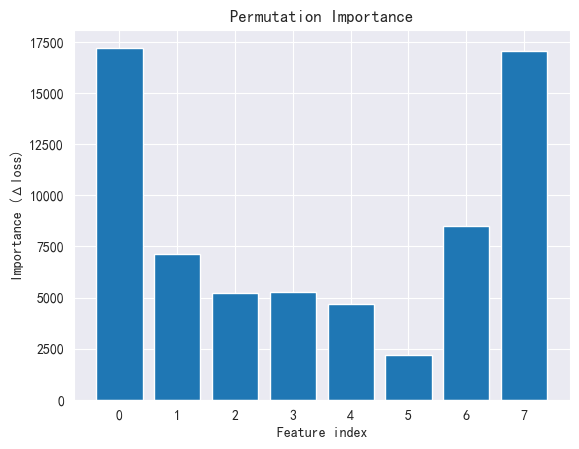

In [12]:
def permutation_importance(model, X_val, y_val, loss_fn, n_repeats=5):
    model.eval()
    with torch.no_grad():
        baseline_loss = float(loss_fn(model(X_val), y_val))
    importances = np.zeros(X_val.shape[1], dtype=float)
    for i in range(X_val.shape[1]):
        losses = []
        for _ in range(n_repeats):
            Xp = X_val.clone()
            idx = torch.randperm(Xp.size(0))
            col = Xp[:, i][idx]
            Xp[:, i] = col
            with torch.no_grad():
                losses.append(float(loss_fn(model(Xp), y_val)))
        importances[i] = np.mean(losses) - baseline_loss
    return importances

# Demo on regression model
X, y = make_regression(n_samples=800, n_features=8, noise=10, random_state=0)
X = torch.tensor(StandardScaler().fit_transform(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

ds = TensorDataset(X, y)
tr_idx, va_idx = np.arange(0,600), np.arange(600,800)
tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=64, shuffle=True)
X_val = X[va_idx]; y_val = y[va_idx]

model = nn.Sequential(nn.Linear(8,64), nn.ReLU(), nn.Linear(64,1))
opt = optim.Adam(model.parameters(), lr=0.01)
crit = nn.MSELoss()

for epoch in range(30):
    model.train()
    for xb, yb in tr_loader:
        loss = crit(model(xb), yb)
        opt.zero_grad(); loss.backward(); opt.step()

imps = permutation_importance(model, X_val, y_val, crit, n_repeats=5)
print('Permutation importances:', imps)
plt.bar(range(len(imps)), imps)
plt.xlabel('Feature index'); plt.ylabel('Importance (Δloss)'); plt.title('Permutation Importance')
plt.show()

## 6. Credit scoring — Stratified 5-fold CV with PyTorch

In [13]:
# Create synthetic imbalanced credit-like dataset
X, y = make_classification(n_samples=4000, n_features=30, n_informative=12,
                           weights=[0.85, 0.15], random_state=7)
X = StandardScaler().fit_transform(X)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)  # as float for BCE
ds = TensorDataset(X_t, y_t)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class CreditNN(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x).squeeze()

criterion = nn.BCELoss()

def train_epoch(model, loader, opt):
    model.train(); losses = []
    for xb, yb in loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

def eval_collect(model, loader):
    model.eval(); ys=[]; scores=[]
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb).squeeze()
            ys.append(yb.numpy()); scores.append(out.numpy())
    y_true = np.concatenate(ys); y_scores = np.concatenate(scores)
    y_pred = (y_scores >= 0.5).astype(int)
    return y_true, y_pred, y_scores

results = []
for fold, (tr, va) in enumerate(skf.split(X, y)):
    tr_loader = DataLoader(Subset(ds, tr), batch_size=64, shuffle=True)
    va_loader = DataLoader(Subset(ds, va), batch_size=256, shuffle=False)

    model = CreditNN(X_t.shape[1])
    opt = optim.Adam(model.parameters(), lr=0.001)

    for _ in range(15): train_epoch(model, tr_loader, opt)

    y_true, y_pred, y_score = eval_collect(model, va_loader)
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc_val = roc_auc_score(y_true, y_score)

    results.append({'confusion_matrix': cm, 'precision': precision,
                    'recall': recall, 'f1': f1, 'roc_auc': auc_val})
    print(f"Fold {fold+1} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {auc_val:.3f}")

print('\nAverages:')
print('Precision:', np.mean([r['precision'] for r in results]).round(3))
print('Recall   :', np.mean([r['recall'] for r in results]).round(3))
print('F1       :', np.mean([r['f1'] for r in results]).round(3))
print('ROC AUC  :', np.mean([r['roc_auc'] for r in results]).round(3))

Fold 1 - Precision: 0.937, Recall: 0.846, F1: 0.889, AUC: 0.978
Fold 2 - Precision: 0.929, Recall: 0.846, F1: 0.885, AUC: 0.965
Fold 3 - Precision: 0.944, Recall: 0.823, F1: 0.879, AUC: 0.977
Fold 4 - Precision: 0.938, Recall: 0.855, F1: 0.895, AUC: 0.975
Fold 5 - Precision: 0.964, Recall: 0.855, F1: 0.906, AUC: 0.978

Averages:
Precision: 0.942
Recall   : 0.845
F1       : 0.891
ROC AUC  : 0.975


## 7. Integrated evaluation workflow (compact demo)

In [14]:
# Compact end-to-end demo using synthetic classification
X, y = make_classification(n_samples=2000, n_features=25, n_informative=12,
                           weights=[0.9, 0.1], random_state=123)
X = StandardScaler().fit_transform(X)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

ds = TensorDataset(X_t, y_t)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

class SimpleClf(nn.Module):
    def __init__(self, d): super().__init__(); self.net = nn.Sequential(nn.Linear(d,64), nn.ReLU(), nn.Linear(64,1), nn.Sigmoid())
    def forward(self,x): return self.net(x).squeeze()

def train_one(model, loader, epochs=8, lr=0.001):
    opt = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for _ in range(epochs):
        for xb, yb in loader:
            loss = F.binary_cross_entropy(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()

metrics = []
for tr, va in skf.split(X, y):
    tr_loader = DataLoader(Subset(ds, tr), batch_size=64, shuffle=True)
    va_loader = DataLoader(Subset(ds, va), batch_size=256, shuffle=False)
    m = SimpleClf(X_t.shape[1]); train_one(m, tr_loader)
    y_true, y_pred, y_prob = [], [], []
    m.eval()
    with torch.no_grad():
        for xb, yb in va_loader:
            prob = m(xb).numpy()
            y_prob.append(prob); y_true.append(yb.numpy())
            y_pred.append((prob>=0.5).astype(int))
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred); y_prob = np.concatenate(y_prob)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc_val = roc_auc_score(y_true, y_prob)
    metrics.append((p,r,f1,auc_val))
    print(f'Fold: P={p:.3f} R={r:.3f} F1={f1:.3f} AUC={auc_val:.3f}')

print('\nAverage over folds:')
print('Precision:', np.mean([m[0] for m in metrics]).round(3))
print('Recall   :', np.mean([m[1] for m in metrics]).round(3))
print('F1       :', np.mean([m[2] for m in metrics]).round(3))
print('ROC AUC  :', np.mean([m[3] for m in metrics]).round(3))

Fold: P=1.000 R=0.190 F1=0.320 AUC=0.950
Fold: P=1.000 R=0.171 F1=0.292 AUC=0.916
Fold: P=1.000 R=0.244 F1=0.392 AUC=0.886
Fold: P=1.000 R=0.220 F1=0.360 AUC=0.875
Fold: P=1.000 R=0.122 F1=0.217 AUC=0.919

Average over folds:
Precision: 1.0
Recall   : 0.189
F1       : 0.316
ROC AUC  : 0.909


## 回归指标与诊断（替代 Boston，使用 California Housing，自动降级为合成数据）

✅ 使用 California Housing 数据
Epoch 10/50  Loss: 0.3496
Epoch 20/50  Loss: 0.3388
Epoch 30/50  Loss: 0.3019
Epoch 40/50  Loss: 0.2993
Epoch 50/50  Loss: 0.2888
MSE: 0.3027
RMSE: 0.5502
MAE: 0.3771
R2: 0.7694


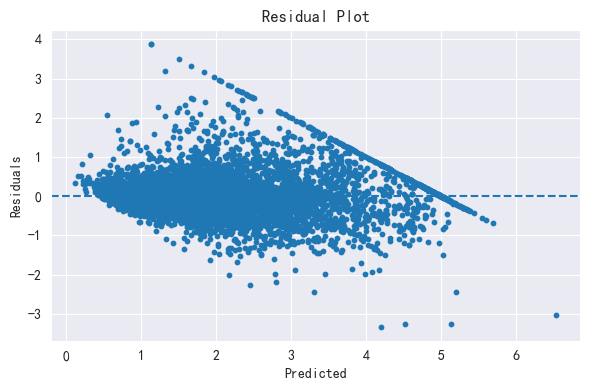

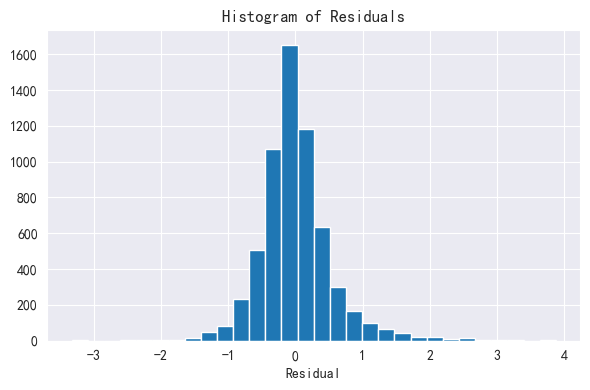

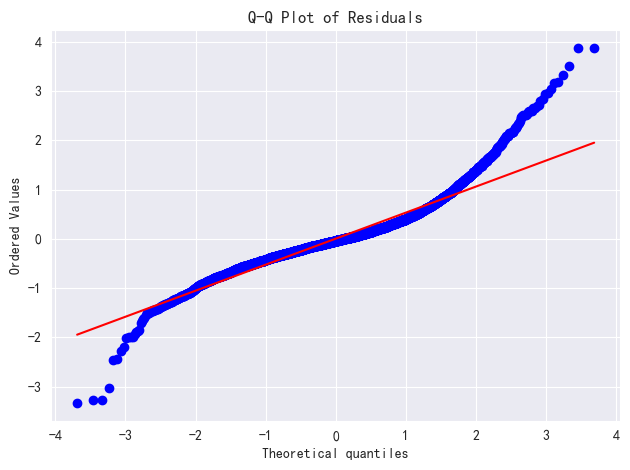

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2815.
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:12:12   Log-Likelihood:                -15823.
No. Observations:               14448   AIC:                         3.166e+04
Df Residuals:                   14439   BIC:                         3.173e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0692      0.006    343.700      0.0

<Figure size 700x300 with 0 Axes>

In [15]:
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score
    from sklearn.datasets import fetch_california_housing
    import scipy.stats as stats
    import statsmodels.api as sm

    # 尝试加载 California Housing 数据集；若失败则退回到合成数据
    try:
        data = fetch_california_housing(as_frame=True)
        df = data.frame.copy()
        X = df.drop(columns=['MedHouseVal']).values
        y = df['MedHouseVal'].values
        feature_names = list(df.columns.drop('MedHouseVal'))
        print("✅ 使用 California Housing 数据")
    except Exception as e:
        print("ℹ️ California Housing 加载失败，改用合成数据：", e)
        from sklearn.datasets import make_regression
        X, y = make_regression(n_samples=1000, n_features=8, noise=20, random_state=42)
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
    y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

    class RegressionModel(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        def forward(self, x):
            return self.net(x)

    model = RegressionModel(X_train_t.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # 训练
    for epoch in range(50):
        model.train()
        total = 0.0
        for xb, yb in train_dl:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total += loss.item() * xb.size(0)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/50  Loss: {total/len(train_dl.dataset):.4f}")

    # 评估
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test_t).squeeze()
        y_true = y_test_t.squeeze()

    mse = nn.MSELoss()(preds_test, y_true).item()
    rmse = mse ** 0.5
    mae = torch.mean(torch.abs(preds_test - y_true)).item()
    r2  = r2_score(y_true.numpy(), preds_test.numpy())

    print(f"MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR2: {r2:.4f}")

    # 残差分析
    residuals = (y_true - preds_test).numpy()
    plt.figure(figsize=(6,4))
    plt.scatter(preds_test.numpy(), residuals, s=10)
    plt.axhline(0, linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()

    # 残差直方图
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual')
    plt.title('Histogram of Residuals')
    plt.tight_layout()
    plt.show()

    # Q-Q 图
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.tight_layout()
    plt.show()

    # statsmodels 线性回归摘要与影响度量（可选）
    try:
        X_train_sm = sm.add_constant(X_train_s)
        ols = sm.OLS(y_train, X_train_sm).fit()
        print(ols.summary())
        infl = ols.get_influence()
        cooks_d = infl.cooks_distance[0]
        import numpy as np
        import matplotlib.pyplot as plt
        plt.figure(figsize=(7,3))
        plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
        plt.title("Cook's Distance")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("ℹ️ statsmodels 影响度量步骤跳过：", e)

except Exception as e:
    print("❌ 回归指标与诊断单元执行失败：", e)


## 综合模型评估工作流（分层K折 + 精准/召回/F1/ROC-AUC）

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# 生成可复现实验数据
rng = np.random.RandomState(42)
X = rng.randn(1200, 12).astype(np.float32)
y = (X[:, :3].sum(axis=1) + rng.randn(1200)*0.5 > 0).astype(int)

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_t, y_t)

class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        out = model(xb).squeeze()
        loss = criterion(out, yb.float())
        loss.backward()
        optimizer.step()

def eval_loader(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb).squeeze()
            ys.append(yb.numpy())
            ps.append(out.numpy())
    import numpy as np
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc = roc_auc_score(y_true, y_prob)
    return p, r, f1, auc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

for fold, (tr, va) in enumerate(skf.split(X, y), 1):
    train_loader = DataLoader(Subset(dataset, tr), batch_size=64, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, va), batch_size=256)
    model = Classifier(X_t.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()
    for _ in range(10):
        train_epoch(model, train_loader, optimizer, criterion)
    p, r, f1, auc = eval_loader(model, val_loader)
    metrics.append((p, r, f1, auc))
    print(f"Fold {fold}  P={p:.3f}  R={r:.3f}  F1={f1:.3f}  AUC={auc:.3f}")

avg = np.array(metrics).mean(axis=0)
print(f"\nAverage  P={avg[0]:.3f}  R={avg[1]:.3f}  F1={avg[2]:.3f}  AUC={avg[3]:.3f}")


Fold 1  P=0.902  R=0.902  F1=0.902  AUC=0.971
Fold 2  P=0.890  R=0.926  F1=0.908  AUC=0.961
Fold 3  P=0.893  R=0.885  F1=0.889  AUC=0.969
Fold 4  P=0.866  R=0.909  F1=0.887  AUC=0.967
Fold 5  P=0.947  R=0.893  F1=0.919  AUC=0.981

Average  P=0.899  R=0.903  F1=0.901  AUC=0.970
